## Designing a Data Science Workflow

The purpose of this mission is to practice working with data workflows.  A data workflow implies doing data science investigation using a series of functions. These functions are easily called and so streamline the process of model design by facilitating incremental parameter and hyperparameter adjustments to the model. Also functions are used in the data cleaning, and variable design process, so that these two components can also be optimized for.

In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [22]:
from jupyterthemes import jtplot
jtplot.style()

In [23]:
train = pd.read_csv("train.csv")
holdout = pd.read_csv("test.csv")

In [24]:
holdout.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [25]:
# %load functions.py
def process_missing(df):
    """Handle various missing values from the data set

    Usage
    ------

    holdout = process_missing(holdout)
    """
    df["Fare"] = df["Fare"].fillna(train["Fare"].mean())
    df["Embarked"] = df["Embarked"].fillna("S")
    return df

def process_age(df):
    """Process the Age column into pre-defined 'bins' 

    Usage
    ------

    train = process_age(train)
    """
    df["Age"] = df["Age"].fillna(-0.5)
    cut_points = [-1,0,5,12,18,35,60,100]
    label_names = ["Missing","Infant","Child","Teenager","Young Adult","Adult","Senior"]
    df["Age_categories"] = pd.cut(df["Age"],cut_points,labels=label_names)
    return df

def process_fare(df):
    """Process the Fare column into pre-defined 'bins' 

    Usage
    ------

    train = process_fare(train)
    """
    cut_points = [-1,12,50,100,1000]
    label_names = ["0-12","12-50","50-100","100+"]
    df["Fare_categories"] = pd.cut(df["Fare"],cut_points,labels=label_names)
    return df

def process_cabin(df):
    """Process the Cabin column into pre-defined 'bins' 

    Usage
    ------

    train process_cabin(train)
    """
    df["Cabin_type"] = df["Cabin"].str[0]
    df["Cabin_type"] = df["Cabin_type"].fillna("Unknown")
    df = df.drop('Cabin',axis=1)
    return df

def process_titles(df):
    """Extract and categorize the title from the name column 

    Usage
    ------

    train = process_titles(train)
    """
    titles = {
        "Mr" :         "Mr",
        "Mme":         "Mrs",
        "Ms":          "Mrs",
        "Mrs" :        "Mrs",
        "Master" :     "Master",
        "Mlle":        "Miss",
        "Miss" :       "Miss",
        "Capt":        "Officer",
        "Col":         "Officer",
        "Major":       "Officer",
        "Dr":          "Officer",
        "Rev":         "Officer",
        "Jonkheer":    "Royalty",
        "Don":         "Royalty",
        "Sir" :        "Royalty",
        "Countess":    "Royalty",
        "Dona":        "Royalty",
        "Lady" :       "Royalty"
    }
    extracted_titles = df["Name"].str.extract(' ([A-Za-z]+)\.',expand=False)
    df["Title"] = extracted_titles.map(titles)
    return df

def create_dummies(df,column_name):
    """Create Dummy Columns (One Hot Encoding) from a single Column

    Usage
    ------

    train = create_dummies(train,"Age")
    """
    dummies = pd.get_dummies(df[column_name],prefix=column_name)
    df = pd.concat([df,dummies],axis=1)
    return df

In [26]:
def processing(df):
    df = process_missing(df)
    df = process_age(df)
    df = process_fare(df)
    df = process_titles(df)
    df = process_cabin(df)
    
    columns = ["Age_categories","Fare_categories","Title","Cabin_type","Sex"]
    for col in columns:
        df = create_dummies(df, col)
    return df

In [27]:
train = processing(train)
holdout = processing(holdout)

In [28]:
train[["SibSp","Parch"]].describe()

,SibSp,Parch
count,891.000000,891.000000
mean,0.523008,0.381594
std,1.102743,0.806057
min,0.000000,0.000000
25%,0.000000,0.000000
50%,0.000000,0.000000
75%,1.000000,0.000000
max,8.000000,6.000000


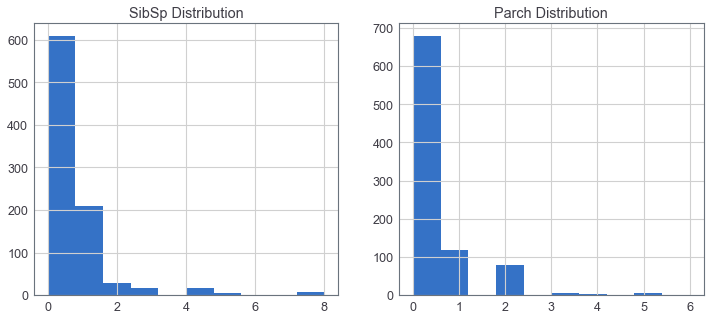

In [29]:
fig = plt.figure(figsize=(12,5))

ax1 = fig.add_subplot(1,2,1)
ax2 = fig.add_subplot(1,2,2)

ax1.hist(train['SibSp'])
ax2.hist(train['Parch'])

ax1.set_title('SibSp Distribution')
ax2.set_title('Parch Distribution')
plt.show()

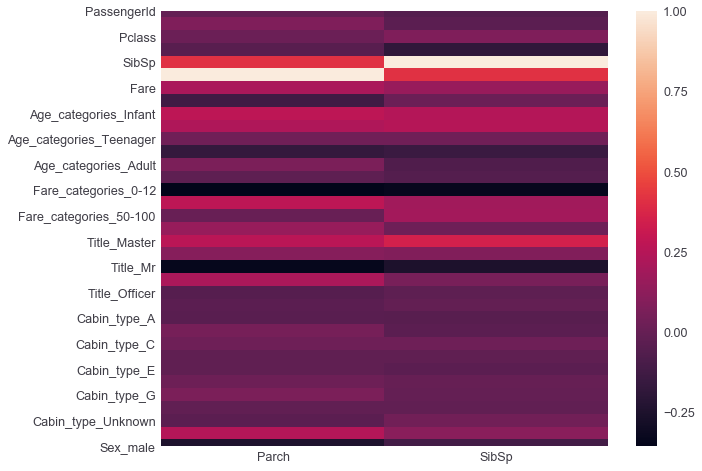

In [30]:
plt.figure(figsize=(10,8))
sns.heatmap(train.corr()[["Parch","SibSp"]])

In [31]:
train.pivot_table(values=["Parch","SibSp"],index='Survived', aggfunc=[np.mean, np.std, np.ma.count])

mean                 std           count      
             Parch     SibSp     Parch     SibSp Parch SibSp
Survived                                                    
0         0.329690  0.553734  0.823166  1.288399   549   549
1         0.464912  0.473684  0.771712  0.708688   342   342

In [32]:
explore = train[["Parch","SibSp","Survived"]].copy()
explore["parchsimp"] = pd.cut(explore["Parch"],bins=[-0.5,0.5,3.5,9],labels=["None","1-3","4+"])
explore["sibspsimp"] = pd.cut(explore["SibSp"],bins=[-0.5,0.5,3.5,9],labels=["None","1-3","4+"])

explore["famsize"] = explore[["Parch","SibSp"]].sum(axis=1)
explore["famsimp"] = pd.cut(explore["famsize"],bins=[-0.5,0.5,3.5,10.5],labels=["None","1-3","4+"])

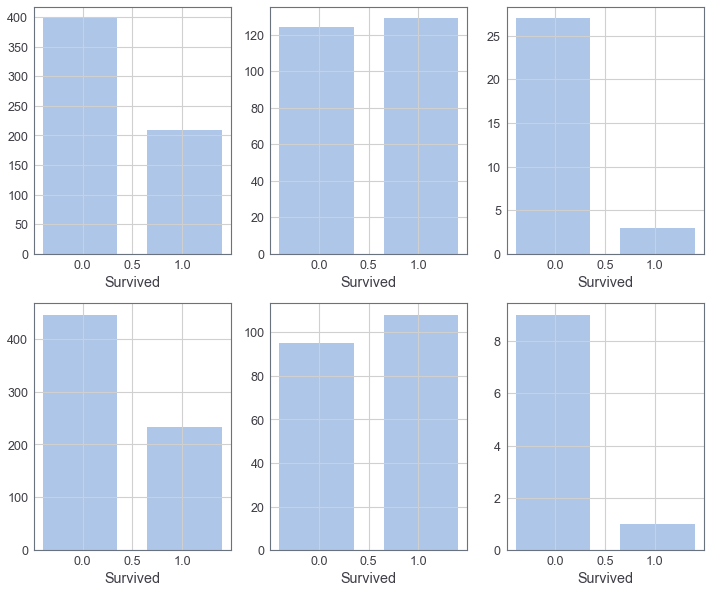

In [33]:
jtplot.style()

# g = sns.FacetGrid(explore,col="parchsimp",col_wrap=4, height=6,aspect=0.7,ylim=(0,1.6))

# g.map(sns.distplot,"Survived",bins=[-0.4,0.35,0.65,1.4], hist_kws={"density":True,"alpha":0.6},color='orange',kde=False)
#print(g.axes)
# fig,ax = plt.subplots(2,1, figsize=(12,10))
loop_list = ["None","1-3","4+"]

fig,axes = plt.subplots(2,3,figsize=(12,10))
for i,loop in enumerate(loop_list):
    f = sns.distplot(explore.loc[explore.sibspsimp == loop]["Survived"],bins=[-0.4,0.35,0.65,1.4], kde=False, ax=axes[0,i])
    h = sns.distplot(explore.loc[explore.parchsimp == loop]["Survived"],bins=[-0.4,0.35,0.65,1.4], kde=False, ax=axes[1,i])

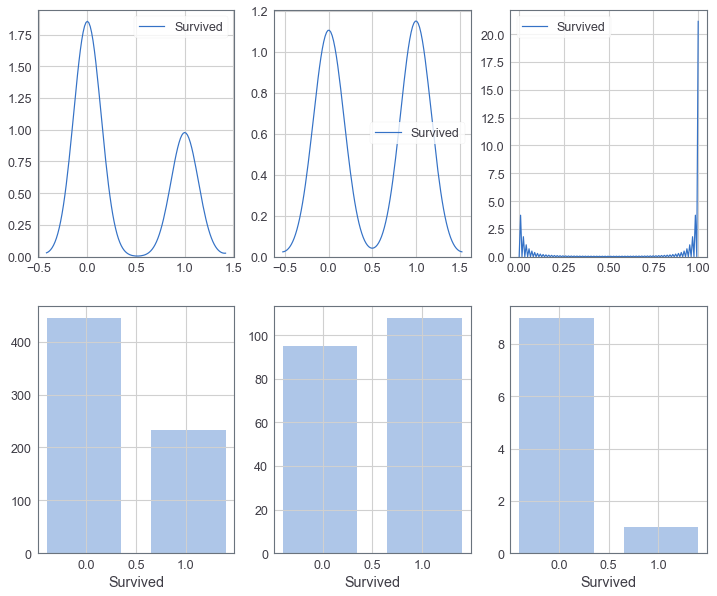

In [53]:
jtplot.style()

# g = sns.FacetGrid(explore,col="parchsimp",col_wrap=4, height=6,aspect=0.7,ylim=(0,1.6))

# g.map(sns.distplot,"Survived",bins=[-0.4,0.35,0.65,1.4], hist_kws={"density":True,"alpha":0.6},color='orange',kde=False)
#print(g.axes)
# fig,ax = plt.subplots(2,1, figsize=(12,10))
loop_list = ["None","1-3","4+"]

fig,axes = plt.subplots(2,3,figsize=(12,10))
for i,loop in enumerate(loop_list):
    f = sns.kdeplot(explore.loc[explore.sibspsimp == loop]["Survived"], ax=axes[0,i])
    h = sns.distplot(explore.loc[explore.parchsimp == loop]["Survived"],bins=[-0.4,0.35,0.65,1.4], kde=False, ax=axes[1,i])

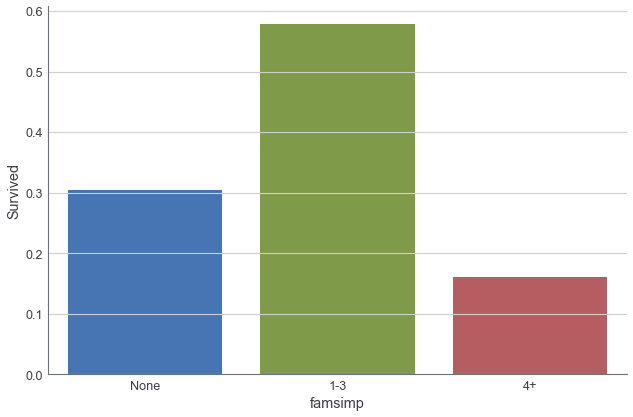

In [34]:
g = sns.catplot(y="Survived",x="famsimp",kind="bar",data=explore, height=6,aspect=1.5, ci=None)

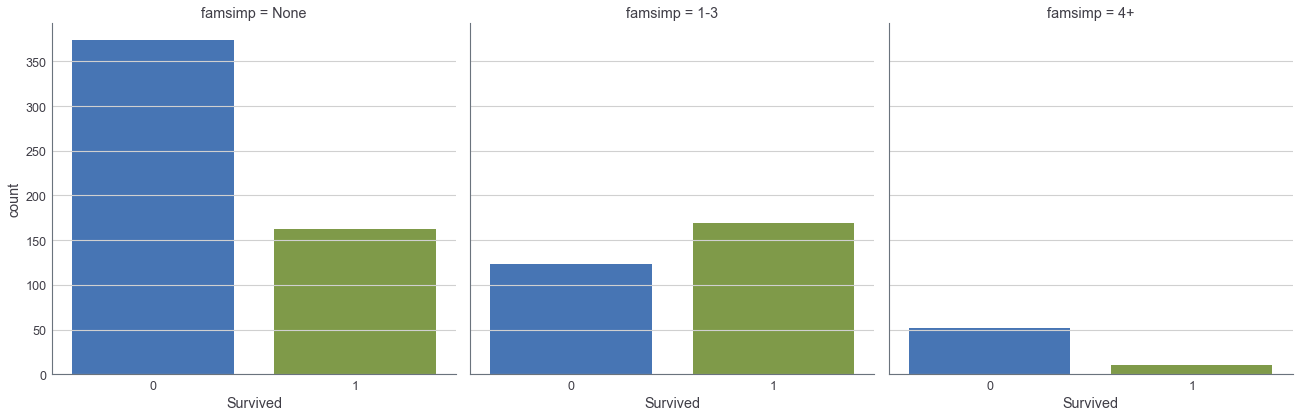

In [35]:
g = sns.catplot(x="Survived",col="famsimp",kind="count",data=explore, height=6,aspect=1)

With no other family onboard a passenger had only a 30% chance of survival, with between one and three family members the passengers change of survival leapt up to over 57%, then with a family of four or more others the passenger's chances fell to below 20%.

To account for this let's create a dummy feature for whether or not the passenger had any other family onboard.

In [36]:
def process_famsize(size):
    category = None
    if size == 0:
        category = "None"
    elif size <= 3:
        category = "1-3"
    else:
        category = "4+"
    return category

In [37]:
train["famsize"] = train[["SibSp","Parch"]].sum(axis=1)
holdout["famsize"] = holdout[["SibSp","Parch"]].sum(axis=1)

train["FamCat"] = train["famsize"].apply(process_famsize)
holdout["FamCat"] = holdout["famsize"].apply(process_famsize)

dummies_t = pd.get_dummies(train["FamCat"],prefix="FamCat")
dummies_h = pd.get_dummies(holdout["FamCat"],prefix="FamCat")
train = pd.concat([train,dummies_t], axis=1).drop(columns="FamCat")
holdout = pd.concat([holdout,dummies_h], axis=1).drop(columns="FamCat")

In [50]:
train.select_dtypes("number").head()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,Age_categories_Missing,Age_categories_Infant,Age_categories_Child,...,Cabin_type_F,Cabin_type_G,Cabin_type_T,Cabin_type_Unknown,Sex_female,Sex_male,famsize,FamCat_1-3,FamCat_4+,FamCat_None
0,1,0,3,22.0,1,0,7.2500,0,0,0,...,0,0,0,1,0,1,1,1,0,0
1,2,1,1,38.0,1,0,71.2833,0,0,0,...,0,0,0,0,1,0,1,1,0,0
2,3,1,3,26.0,0,0,7.9250,0,0,0,...,0,0,0,1,1,0,0,0,0,1
3,4,1,1,35.0,1,0,53.1000,0,0,0,...,0,0,0,0,1,0,1,1,0,0
4,5,0,3,35.0,0,0,8.0500,0,0,0,...,0,0,0,1,0,1,0,0,0,1


In [39]:
from sklearn.feature_selection import RFECV
from sklearn.ensemble import RandomForestClassifier

In [40]:
def select_features(df):
    df = df.select_dtypes("number")
    df = df.dropna(axis=1)
    
    all_X = df.drop(columns=["PassengerId",
                            "Survived","famsize"], errors='ignore')
    all_y = df["Survived"]

    clf = RandomForestClassifier(n_estimators=10,random_state=1)
    selector = RFECV(clf,cv=10)
    selector.fit(all_X,all_y)
    
    best_columns = list(all_X.columns[selector.support_])
    print("Best Columns \n"+"\n{}\n".format(best_columns))
    
    return best_columns
cols = select_features(train)

Best Columns 

['Pclass', 'Age', 'SibSp', 'Parch', 'Fare', 'Age_categories_Missing', 'Age_categories_Infant', 'Age_categories_Child', 'Age_categories_Teenager', 'Age_categories_Young Adult', 'Age_categories_Adult', 'Age_categories_Senior', 'Fare_categories_0-12', 'Fare_categories_12-50', 'Fare_categories_50-100', 'Fare_categories_100+', 'Title_Master', 'Title_Miss', 'Title_Mr', 'Title_Mrs', 'Title_Officer', 'Cabin_type_A', 'Cabin_type_B', 'Cabin_type_C', 'Cabin_type_D', 'Cabin_type_E', 'Cabin_type_F', 'Cabin_type_Unknown', 'Sex_female', 'Sex_male', 'FamCat_1-3', 'FamCat_4+', 'FamCat_None']



In [41]:
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

In [42]:
def select_model(df,features):
    all_X = df[features]
    all_y = df["Survived"]
    
    solver_params = [{
        "name":"LogisticRegression",
        "estimator":LogisticRegression(),
        "hyperparameters":{
            "solver":["newton-cg","lbfgs","liblinear"]
        }},
    {
        "name":"KNeighborsClassifier",
        "estimator":KNeighborsClassifier(),
        "hyperparameters":{
            "n_neighbors": range(1,20,2),
            "weights": ["distance","uniform"],
            "algorithm": ["ball_tree","kd_tree","brute"],
            "p": [1,2]
        }},
    {
        "name":"RandomForestClassifier",
        "estimator": RandomForestClassifier(),
        "hyperparameters":{
            "n_estimators":[4,6,9],
            "criterion": ["entropy","gini"],
            "max_depth": [2,5,10],
            "max_features": ["log2","sqrt"],
            "min_samples_leaf": [1,5,8],
            "min_samples_split": [2,3,5]
        }}]
    for dic in solver_params:
        print(dic["name"])
        grid = GridSearchCV(dic["estimator"],param_grid=dic["hyperparameters"],cv=10)
        grid.fit(all_X,all_y)
        dic["best_score"] = grid.best_score_
        dic["best_params"] = grid.best_params_
        dic["best_estimator"] = grid.best_estimator_
        print("Best Parameters:\t{}\nBest Score\t{}".format(dic["best_params"],dic["best_score"]))
    
    return solver_params

In [43]:
grid_results = select_model(train,cols)

LogisticRegression


C:\Users\isaac\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\isaac\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\isaac\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\isaac\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\isaac\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", Convergenc

Best Parameters:	{'solver': 'newton-cg'}
Best Score	0.8237934904601572
KNeighborsClassifier


C:\Users\isaac\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Best Parameters:	{'algorithm': 'kd_tree', 'n_neighbors': 3, 'p': 1, 'weights': 'uniform'}
Best Score	0.7867564534231201
RandomForestClassifier
Best Parameters:	{'criterion': 'gini', 'max_depth': 10, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 4}
Best Score	0.8462401795735129


C:\Users\isaac\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [44]:
grid_results

[{'name': 'LogisticRegression',
  'estimator': LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                     intercept_scaling=1, l1_ratio=None, max_iter=100,
                     multi_class='warn', n_jobs=None, penalty='l2',
                     random_state=None, solver='warn', tol=0.0001, verbose=0,
                     warm_start=False),
  'hyperparameters': {'solver': ['newton-cg', 'lbfgs', 'liblinear']},
  'best_score': 0.8237934904601572,
  'best_params': {'solver': 'newton-cg'},
  'best_estimator': LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                     intercept_scaling=1, l1_ratio=None, max_iter=100,
                     multi_class='warn', n_jobs=None, penalty='l2',
                     random_state=None, solver='newton-cg', tol=0.0001, verbose=0,
                     warm_start=False)},
 {'name': 'KNeighborsClassifier',
  'estimator': KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='m

Now that the grid search function is complete, let's create a simple function to more easily format results for Kaggle submission.

In [47]:
def save_submission_file(model,col_list,filename="submission.csv"):
    prediction = model.predict(holdout[col_list])
    submission_dic = {"PassengerId":holdout["PassengerId"],
                     "Survived":prediction}
    submission_df = pd.DataFrame(submission_dic)
    submission_df.to_csv(filename,index=False)

save_submission_file(grid_results[2]["best_estimator"],cols)

In [46]:
grid_results[2]

{'name': 'RandomForestClassifier',
 'estimator': RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                        max_depth=None, max_features='auto', max_leaf_nodes=None,
                        min_impurity_decrease=0.0, min_impurity_split=None,
                        min_samples_leaf=1, min_samples_split=2,
                        min_weight_fraction_leaf=0.0, n_estimators='warn',
                        n_jobs=None, oob_score=False, random_state=None,
                        verbose=0, warm_start=False),
 'hyperparameters': {'n_estimators': [4, 6, 9],
  'criterion': ['entropy', 'gini'],
  'max_depth': [2, 5, 10],
  'max_features': ['log2', 'sqrt'],
  'min_samples_leaf': [1, 5, 8],
  'min_samples_split': [2, 3, 5]},
 'best_score': 0.8462401795735129,
 'best_params': {'criterion': 'gini',
  'max_depth': 10,
  'max_features': 'log2',
  'min_samples_leaf': 1,
  'min_samples_split': 2,
  'n_estimators': 4},
 'best_estimator': RandomForestClassifier(bo